In [95]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy import stats

In [96]:
kendaraan = pd.read_csv("kendaraan_test.csv")
print(len(kendaraan))
kd = kendaraan[kendaraan.SIM != 0]
print(len(kd))

47639
47540


#Pre Processing

In [97]:
def toNumeric(dataset) :
  tmp = dataset.copy()
  listcol = list(tmp.columns)
  datatypecol = dict(tmp.dtypes)
  variasi = []
  for x in listcol:
    if datatypecol.get(x) == "object" :
      variasi.append((x,list(dataset.groupby(x).groups.keys())))
  for x in variasi:
    #tmp[x[0]] = tmp[x[0]].replace([])
    for i in x[1] :
      idx = x[1].index(i)
      tmp[x[0]] = tmp[x[0]].replace([i],idx)

  return tmp

numerick = toNumeric(kendaraan)
numerick.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,49,1,8,0,0,0,46963,26,145,0
1,0,22,1,47,1,1,1,39624,152,241,0
2,0,24,1,28,1,1,1,110479,152,62,0
3,0,46,1,8,1,0,1,36266,124,34,0
4,0,35,1,23,0,0,0,26963,152,229,0


In [98]:
def DoNotDropList(dataset):
  dropnanlist = []
  datatypecol = dict(dataset.dtypes)
  listcol = list(dataset.columns)
  for x in listcol:
    ngroup = dataset.groupby(x).ngroups
    if ngroup > 5:
      dropnanlist.append(x)
  return dropnanlist
  
nodrop = DoNotDropList(numerick) 
print(nodrop)

['Umur', 'Kode_Daerah', 'Premi', 'Kanal_Penjualan', 'Lama_Berlangganan']


In [99]:
def FillNanSkew(dataset):
  dndlist = DoNotDropList(dataset)
  skew = dataset[dndlist].skew(axis=0, skipna=True)
  #jika nilai skewness diantara -2 sampai 2 maka menggunakan mean, jika tidak maka menggunakan median
  for i in range(len(skew)):
    if skew[i] > -2 and skew[i] < 2 :
      dataset[dndlist[i]].fillna(dataset[dndlist[i]].mean(),inplace=True)
    else:
      dataset[dndlist[i]].fillna(dataset[dndlist[i]].median(),inplace=True)
  return dataset

numerick.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,49,1,8,0,0,0,46963,26,145,0
1,0,22,1,47,1,1,1,39624,152,241,0
2,0,24,1,28,1,1,1,110479,152,62,0
3,0,46,1,8,1,0,1,36266,124,34,0
4,0,35,1,23,0,0,0,26963,152,229,0


In [100]:
def DropNan(dataset):
  droplist = []
  datatypecol = dict(dataset.dtypes)
  listcol = list(dataset.columns)
  for x in listcol:
    ngroup = dataset.groupby(x).ngroups
    if ngroup <= 5:
      dataset = dataset[dataset[x].notna()]
  return dataset

print(DropNan(numerick))  

       Jenis_Kelamin  Umur  SIM  ...  Kanal_Penjualan  Lama_Berlangganan  Tertarik
0                  1    49    1  ...               26                145         0
1                  0    22    1  ...              152                241         0
2                  0    24    1  ...              152                 62         0
3                  0    46    1  ...              124                 34         0
4                  0    35    1  ...              152                229         0
...              ...   ...  ...  ...              ...                ...       ...
47634              0    61    1  ...              124                 67         0
47635              0    41    1  ...              157                232         0
47636              0    24    1  ...              152                211         0
47637              0    59    1  ...               26                239         1
47638              0    52    1  ...              124                170         0

[47

In [168]:
def PreProcessing(dataset):
  
  try:
    dataset = dataset.drop(columns=['id'])
  except:
    dataset = dataset
  dataset = dataset.drop_duplicates() #drop duplicate values
  dataset = toNumeric(dataset)        #changing enum value to their index
  dataset = FillNanSkew(dataset)      #Fill the NaN values
  dataset = DropNan(dataset)          #Drop the row if the data was enum
  try:
    #khusus untuk csv kendaraan
    dataset = dataset[dataset.SIM != 0]
    dataset = dataset.drop(columns=['SIM'])
  except:
    dataset = dataset
  finally:
    z_scores = stats.zscore(dataset)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    dataset = dataset[filtered_entries]
  return dataset

print(len(kendaraan))
prep = PreProcessing(kendaraan)
print(len(prep))
prep.head()

47639
47285


,Jenis_Kelamin,Umur,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,49,8,0,0,0,46963,26,145,0
1,0,22,47,1,1,1,39624,152,241,0
3,0,46,8,1,0,1,36266,124,34,0
4,0,35,23,0,0,0,26963,152,229,0
5,0,26,28,1,1,1,42721,152,198,0


# Pemodelan


Convert Dataset to List for convenient 

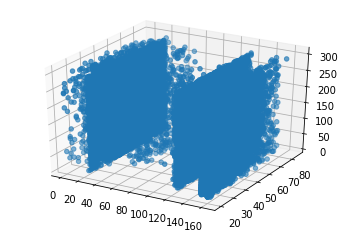

In [102]:
def DatasetToList(dataset,cols =[]):
  if cols == [] :
    cols=dataset.columns
  #ambil 2 kolom dari dataset
  dataset_matrix = dataset[cols].copy(deep=True)
  #urutkan data dari yang terkecil sampai terbesar
  try:
    dataset_matrix.sort_values(by=cols, inplace=True)
  #rubah menjadi array
    dataset_arr = np.array(dataset_matrix)
    return dataset_arr.tolist()
  except:
    return dataset

d = DatasetToList(prep,['Kanal_Penjualan','Umur','Lama_Berlangganan'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = []
y = []
z = []
for i in d:
  x.append(i[0])
  y.append(i[1])
  z.append(i[2])
ax.scatter(*zip(*d))
#plt.legend()
plt.show()

Calculate the distances with euclidean

In [116]:
def euclidean(p1,p2):
  totalMargin = 0
  try:
    for i in range(len(p1)):
      margin = p1[i] - p2[i]
      pmargin = margin**2
      totalMargin = totalMargin + pmargin

    return totalMargin**(1/2)
  except:
    return 0

a = [4,1]
b = [3,9]
print(euclidean(a,b))

8.06225774829855


Calculate the data range in every column

In [104]:
def MinMax(arr):
  minmax = []
  for i in range(len(arr[0])) :
    tmp = []
    for j in range(len(arr)):
      tmp.append(arr[j][i])
    minmax.append([min(tmp),max(tmp)])
  return minmax

print(MinMax(d))

[[1, 163], [20, 85], [10, 299]]


Place k amount of random centeroid

In [144]:
import random as rand
def RandomCenteroid(k,arr):
  kcenter = []
  minmax = MinMax(arr)
  for i in range(k):
    y=0
    center=[]
    for j in minmax:
      try:
        y = rand.randrange(j[0],j[1])
      except:
        y = rand.uniform(j[0],j[1])
      center.append(y)
    kcenter.append(center)
  return kcenter

rc = RandomCenteroid(3,d)
print(rc)

[[11, 37.98671111128377], [1422, 36.86897480878383], [3414, 34.777913987240986]]


Calculate the mean of the list

In [114]:
def MatrixMean(arr):
  matrix = []
  try:
    for i in range(len(arr[0])):
      tmp = []
      j = 0
      for j in range(len(arr)):
        tmp.append(arr[j][i])
      mean = sum(tmp)/len(tmp)
      matrix.append(mean)
  except:
    print(len(arr))
    matrix = []
  return matrix
print(MatrixMean(d))

[0.49602519052617167, 0.4596905946241957]


Clustering the list based on the centeroids

In [108]:
def ClusterArray(arr,centeroids):
  kcluster = []
  for j in range(len(centeroids)):
    kcluster.append([])
  for i in range(len(arr)):
    ranges = []
    for c in centeroids:
      r = euclidean(arr[i],c)
      ranges.append(r)
    m = min(ranges)
    idx = ranges.index(m)
    kcluster[idx].append(arr[i])
  return kcluster

ca = ClusterArray(d,rc)
print(len(ca[1]))

12608


To calculate how varient the data is

In [24]:
def ScoreVariasi(arr):
  data=[]
  for i in arr :
    data.append(len(i))
  total = 0
  for x in data:
    total = total + x
  mean = total / len(data)
  total = 0
  for x in data:
    total = total + abs(x-mean)
  return total / len(data)

data=[]
for i in ca :
  data.append(len(i))
print(data)
print(ScoreVariasi(ca))

[21325, 8577, 17383]
4789.777777777778


K-Mean processing

In [25]:
def kMeanIteration(arr,centeroids):
  cen = centeroids
  clustered = ClusterArray(arr,cen)
  cur_var = ScoreVariasi(clustered)
  counter = 0
  while True:
    cen = []
    for x in clustered:
      cen.append(MatrixMean(x))
    clustered = ClusterArray(arr,cen)
    this_var = ScoreVariasi(clustered)
    if this_var == cur_var :
      counter=counter+1
    else:
      cur_var = this_var
    if counter >= 2 :
      break
  return clustered,cen

result,centeroids = kMeanIteration(d,rc)
print(result)
data=[]
for i in result :
  data.append(len(i))
print(centeroids)
print(data)
print(ScoreVariasi(result))

[[[47, 48, 153], [52, 45, 150], [52, 45, 160], [52, 48, 157], [52, 51, 157], [52, 53, 150], [52, 71, 158], [54, 42, 163], [55, 42, 153], [55, 44, 158], [55, 44, 158], [55, 50, 159], [55, 51, 147], [55, 56, 156], [55, 56, 161], [55, 64, 151], [58, 67, 152], [60, 36, 147], [60, 40, 149], [60, 45, 161], [61, 37, 167], [61, 38, 148], [61, 43, 145], [61, 46, 151], [61, 49, 145], [61, 49, 160], [61, 69, 149], [61, 70, 154], [61, 71, 149], [61, 77, 160], [63, 61, 145], [65, 58, 161], [66, 55, 147], [70, 47, 146], [86, 58, 158], [87, 35, 140], [90, 50, 142], [91, 46, 165], [91, 50, 165], [93, 49, 161], [95, 73, 142], [96, 39, 177], [103, 40, 156], [104, 50, 167], [105, 45, 187], [106, 38, 167], [106, 65, 174], [106, 69, 166], [107, 25, 138], [107, 41, 188], [109, 41, 180], [109, 42, 134], [109, 43, 130], [109, 45, 172], [109, 49, 142], [111, 67, 165], [113, 46, 137], [114, 55, 158], [116, 44, 137], [116, 49, 121], [116, 59, 165], [119, 53, 134], [119, 55, 169], [120, 35, 173], [120, 38, 155], 

#View Functions

2D PLOT

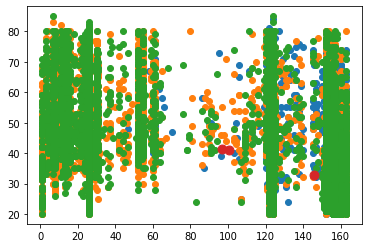

In [27]:
def Scatter2D(clustered,cen):
  for i in range(len(clustered)):
    x = []
    y = []
    for j in clustered[i]:
      x.append(j[0])
      y.append(j[1])
    plt.scatter(x,y)
  x = []
  y = []
  for i in cen:
    x.append(i[0])
    y.append(i[1])
  plt.scatter(x,y , s = 80)
  #plt.legend()
  plt.show()

  

Scatter2D(result,centeroids)

3D PLOT

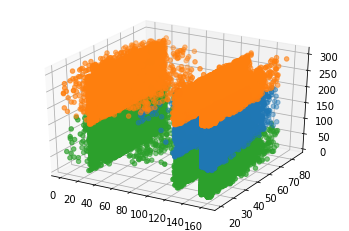

In [26]:
def Scatter3D(clustered,cen):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  for i in range(len(clustered)):
    x = []
    y = []
    z = []
    for j in clustered[i]:
      x.append(j[0])
      y.append(j[1])
      z.append(j[2])
    ax.scatter(x,y,z)
  x = []
  y = []
  z = []
  for i in cen:
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])
  ax.scatter(x,y,z,s=80)
  #plt.legend()
  plt.show()

Scatter3D(result,centeroids)

In [28]:
def CalculateDistortion(clustering,centeroids):
  total = 0
  for i in range(len(clustering)):
    totalpercluster = 0
    for j in range(len(clustering[i])):
      totalrow = 0
      for k in range(len(clustering[i][j])):
        margin = clustering[i][j][k] - centeroids[i][k]
        pmargin = margin**2
        totalrow = totalrow + pmargin
      totalpercluster = totalpercluster + totalrow
    total=total+totalpercluster
  return total

print(CalculateDistortion(result,centeroids))

185220046.5756818


480540046.8046962
232062139.27176023
156121514.84029868
115752402.90935692
65863260.98731093
82554601.35736266
41550728.91297013
46183557.053673305
33896154.339208566


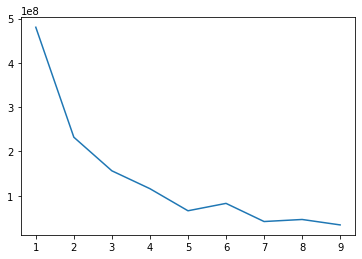

In [29]:
def ElbowDistortion(data):
  x = []
  y = []
  for i in range(1, 10, 1):
    try:
      rc = RandomCenteroid(i,data)
      clustered, cen = kMeanIteration(data,rc)
      print(CalculateDistortion(clustered,cen))
      y.append(CalculateDistortion(clustered,cen))
      x.append(i)
    except:
      break

  plt.plot(x,y)
  plt.show()

ElbowDistortion(d)

#MAIN FUNCTION

In [163]:
train = pd.read_csv("kendaraan_train.csv")
train.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [164]:
dt = PreProcessing(train)
dt.to_csv('processed_kendaraan.csv')
dt.head()

,Jenis_Kelamin,Umur,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1.0,30.0,33.0,1.0,1.0,1.0,28029.0,152.0,97.0,0
1,0.0,48.0,39.0,0.0,2.0,0.0,25800.0,29.0,158.0,0
3,1.0,58.0,48.0,0.0,0.0,1.0,2630.0,124.0,63.0,0
5,0.0,21.0,35.0,1.0,1.0,1.0,22735.0,152.0,171.0,0
8,1.0,20.0,8.0,1.0,1.0,1.0,30786.0,160.0,31.0,0


In [166]:

d = DatasetToList(dt,['Premi','Umur'])
dt.corr()

,Jenis_Kelamin,Umur,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
Jenis_Kelamin,1.000000,-0.141105,-0.001358,0.081448,0.115150,0.091341,-0.001897,0.110589,0.001317,-0.053893
Umur,-0.141105,1.000000,0.041555,-0.248932,-0.511505,-0.261531,0.058211,-0.546431,-0.001148,0.107626
Kode_Daerah,-0.001358,0.041555,1.000000,-0.023091,-0.026701,-0.025780,-0.010184,-0.041549,-0.004159,0.009755
Sudah_Asuransi,0.081448,-0.248932,-0.023091,1.000000,0.174515,0.825428,0.006582,0.214158,0.002812,-0.341207
Umur_Kendaraan,0.115150,-0.511505,-0.026701,0.174515,1.000000,0.174889,0.027020,0.381888,0.002063,-0.103723
Kendaraan_Rusak,0.091341,-0.261531,-0.025780,0.825428,0.174889,1.000000,-0.006398,0.218995,0.001401,-0.354351
Premi,-0.001897,0.058211,-0.010184,0.006582,0.027020,-0.006398,1.000000,-0.109709,0.000518,0.021958
Kanal_Penjualan,0.110589,-0.546431,-0.041549,0.214158,0.381888,0.218995,-0.109709,1.000000,0.000878,-0.138238
Lama_Berlangganan,0.001317,-0.001148,-0.004159,0.002812,0.002063,0.001401,0.000518,0.000878,1.000000,0.000381
Tertarik,-0.053893,0.107626,0.009755,-0.341207,-0.103723,-0.354351,0.021958,-0.138238,0.000381,1.000000


9751213436.95273
3539261806.9303017
1770185831.1661983
1083613644.0407734
742240732.7433141
519581600.91328555
388595564.12721395
299969428.8338336
241127599.31570172


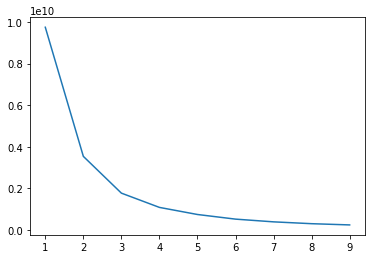

In [157]:

ElbowDistortion(d)

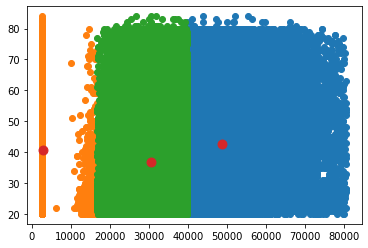

In [167]:
rc = RandomCenteroid(3,d)
kmi,cens = kMeanIteration(d,rc)
Scatter2D(kmi,cens)